In [ ]:
!pip install torch torchvision
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 102.5 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6fupa0zz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6fupa0zz
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=8ebfad235f907017ff4d5fafcc136c957cadef667a05045e693b029b3d2b80c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-fjr78e85/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 24.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd

# Step 1: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset from a CSV file
file_path = '/content/drive/My Drive/Building_images_train//'
# file_path = '/content/drive/My Drive/Building_images/'

In [ ]:
import os
import torch
import clip
from PIL import Image
import numpy as np

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Directory containing your images
image_dir = file_path

def prepare_clip():
    model, preprocess = clip.load("ViT-L/14@336px", device=device)
    return model, preprocess

def preprocess_clip(image_dir, processor, model):
    if not isinstance(image_dir, str):
        raise ValueError("image_dir should be a string representing a valid directory path.")

    image_embeddings = []
    image_paths = []

    for filename in os.listdir(image_dir):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(image_dir, filename)
            image = processor(Image.open(image_path)).unsqueeze(0).to(device)

            with torch.no_grad():
                # Extract image embedding
                image_embedding = model.encode_image(image)
                image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

            # Append embedding and path
            image_embeddings.append(image_embedding.cpu().numpy())
            image_paths.append(image_path)

    # Convert list to numpy array
    image_embeddings = np.vstack(image_embeddings)

    return image_embeddings, model, image_paths

In [ ]:
import numpy as np
import faiss

def embed_clip(image_embeddings):
    # Assume image_embeddings is your embeddings array
    # Ensure it's a NumPy array
    image_embeddings = np.array(image_embeddings)

    # Ensure the data type is float32
    image_embeddings = image_embeddings.astype(np.float32)

    # Ensure the array is contiguous in memory
    image_embeddings = np.ascontiguousarray(image_embeddings)

    # Optional: Normalize embeddings for cosine similarity
    faiss.normalize_L2(image_embeddings)

    # Define the dimension of the embeddings
    dimension = image_embeddings.shape[1]

    # Create an index (Inner Product for cosine similarity)
    index = faiss.IndexFlatIP(dimension)

    # Add embeddings to the index
    index.add(image_embeddings)

    return index

In [ ]:
def search_clip(query, index, model, image_paths, top_k=5):
    # Encode the query text
    text_tokens = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_embedding = model.encode_text(text_tokens)

    # Move to CPU and convert to NumPy array
    text_embedding = text_embedding.cpu().numpy()

    # Ensure the data type is float32
    text_embedding = text_embedding.astype(np.float32)

    # Ensure the array is contiguous in memory
    text_embedding = np.ascontiguousarray(text_embedding)

    # Reshape to (1, dimension)
    text_embedding = text_embedding.reshape(1, -1)

    # Normalize the query vector
    faiss.normalize_L2(text_embedding)

    # Perform the search
    D, I = index.search(text_embedding, top_k)

    mean_score = np.mean(D[0])
    std_dev = np.std(D[0])

    # Set threshold to one standard deviation above the mean
    threshold = mean_score
    # threshold = 0.1

    print(f"Mean Score: {mean_score}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Threshold: {threshold}")

    results = []
    for idx, i in enumerate(I[0]):
        score = D[0][idx]
        if score >= threshold:
            results.append((image_paths[i], score))
        if len(results) == top_k:
            break

    return results

In [ ]:
thing_to_detect = 'bath tub'
print(image_dir)

/content/drive/My Drive/Building_images_train//


Mean Score: 0.18671521544456482
Standard Deviation: 0.010075492784380913
Threshold: 0.18671521544456482
Score: 0.2031


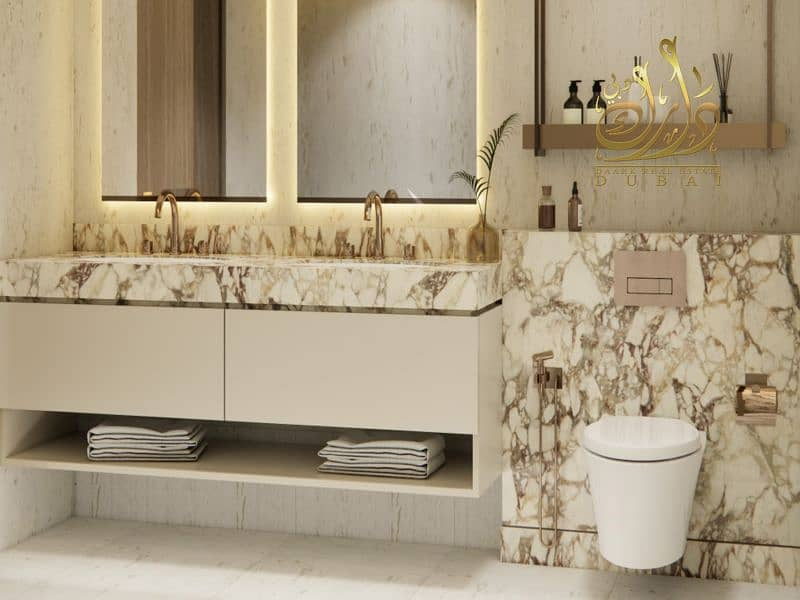

Score: 0.1936


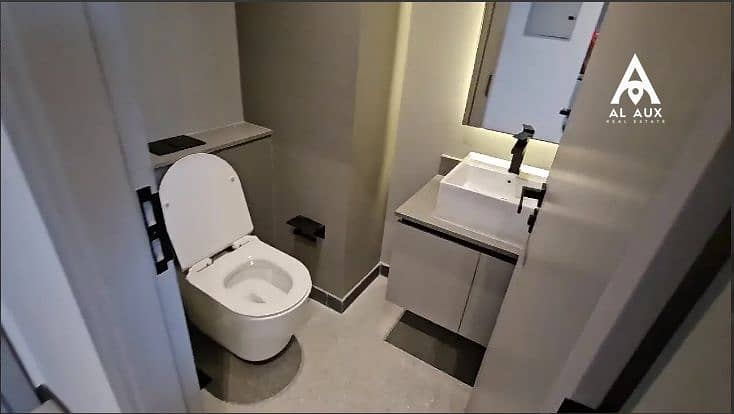

In [ ]:
query = thing_to_detect

model_clip, processor_clip = prepare_clip()
image_embeddings_clip, model_clip, image_paths_clip = preprocess_clip(image_dir=image_dir, processor=processor_clip ,model=model_clip)
index_clip = embed_clip(image_embeddings_clip)
results_clip = search_clip(query, index_clip, model_clip, image_paths_clip, top_k=5)

from IPython.display import Image as IPythonImage, display

for img_path, score in results_clip:
    print(f"Score: {score:.4f}")
    display(IPythonImage(filename=img_path))


In [ ]:
!pip install torch torchvision transformers pillow requests faiss-gpu

In [ ]:
import os
import torch
import faiss
import numpy as np
from PIL import Image
from transformers import AlignProcessor, AlignModel

# file_path = '/content/drive/My Drive/Building_images_test_case/10130844/'
# file_path = '/content/drive/My Drive/Building_images/'
image_dir = file_path
thing_to_detect = 'bath'
query = thing_to_detect


# Load ALIGN processor and model
def prepare_align():
    processor = AlignProcessor.from_pretrained("kakaobrain/align-base")
    model = AlignModel.from_pretrained("kakaobrain/align-base")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()  # Set model to evaluation mode
    return model, processor, device

# Preprocess and encode images
def preprocess_align(image_dir, processor, model, device):
    if not isinstance(image_dir, str):
        raise ValueError("image_dir should be a string representing a valid directory path.")
    image_embeddings = []
    image_paths = []

    for filename in os.listdir(image_dir):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(image_dir, filename)
            try:
                image = Image.open(image_path).convert("RGB")
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                continue
            inputs = processor(images=image, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = model.get_image_features(**inputs)

            embedding = outputs.cpu().numpy()
            image_embeddings.append(embedding)
            image_paths.append(image_path)

    if not image_embeddings:
        raise ValueError("No valid images found in the provided directory.")

    # Convert image embeddings to a NumPy array
    image_embeddings = np.vstack(image_embeddings).astype(np.float32)

    # Verify normalization
    norms = np.linalg.norm(image_embeddings, axis=1)
    if not np.allclose(norms, 1.0, atol=1e-3):
        print("Warning: Image embeddings are not properly normalized. Normalizing now.")
        faiss.normalize_L2(image_embeddings)

    return image_embeddings, image_paths

def embed_align(image_embeddings):
    # Normalize embeddings for FAISS (if not already normalized)
    faiss.normalize_L2(image_embeddings)

    # Create FAISS index for Inner Product (Cosine Similarity)
    dimension = image_embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    index.add(image_embeddings)

    return index

# Define search function
def search_align(query, index, model, processor, image_paths, device, top_k=5):
    # Tokenize and encode the query text
    inputs = processor(text=[query], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.get_text_features(**inputs)
    text_embedding = outputs.cpu().numpy().astype(np.float32)

    # Normalize query embedding
    faiss.normalize_L2(text_embedding)

    # Perform the search
    D, I = index.search(text_embedding, top_k)

    # Optionally, adjust the similarity scores by scaling
    # For example, multiplying by a scaling factor
    scaling_factor = 1.0  # Adjust as needed
    D_scaled = D * scaling_factor

    # You can also dynamically set the threshold based on distribution
    # For example, threshold = mean + 2 * std
    mean_score = D.mean()
    std_score = D.std()
    threshold = mean_score
    # Alternatively, set a fixed threshold
    threshold = 0.115
    print(f"Mean Score: {mean_score}")
    print(f"Standard Deviation: {std_score}")
    print(f"Threshold: {threshold}")

    results = []
    for idx, i in enumerate(I[0]):
        score = D_scaled[0][idx]
        if score >= threshold:
            results.append((image_paths[i], score))

    # If you prefer to return all results sorted by score, uncomment below
    # results = sorted([(image_paths[i], D_scaled[0][idx]) for idx, i in enumerate(I[0])], key=lambda x: x[1], reverse=True)

    return results

In [ ]:
model_align, processor_align, device = prepare_align()
image_embeddings_align, image_paths_align = preprocess_align(
        image_dir=image_dir,
        processor=processor_align,
        model=model_align,
        device=device
    )
index_align = embed_align(image_embeddings_align)
results_align = search_align(
    query=query,
    index=index_align,
    model=model_align,
    processor=processor_align,
    image_paths=image_paths_align,
    device=device,
    top_k=10
)

Score: 0.1478


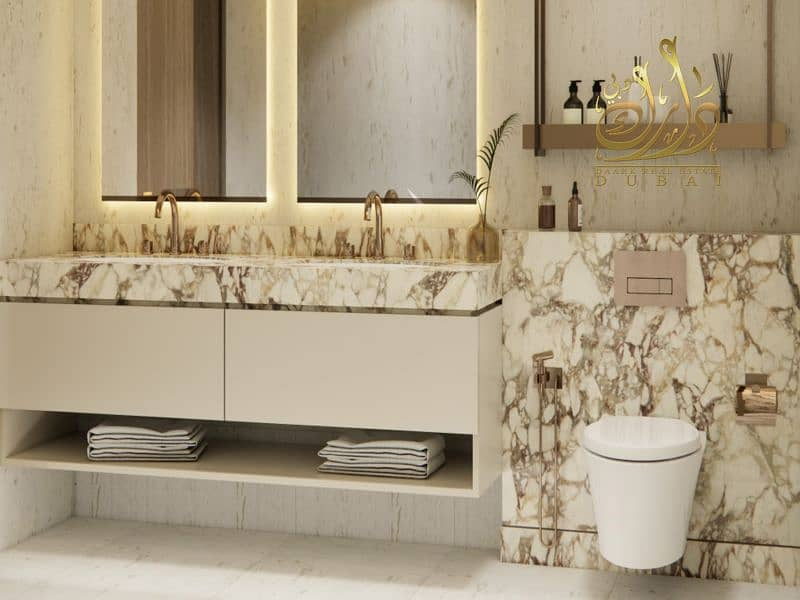

Score: 0.1449


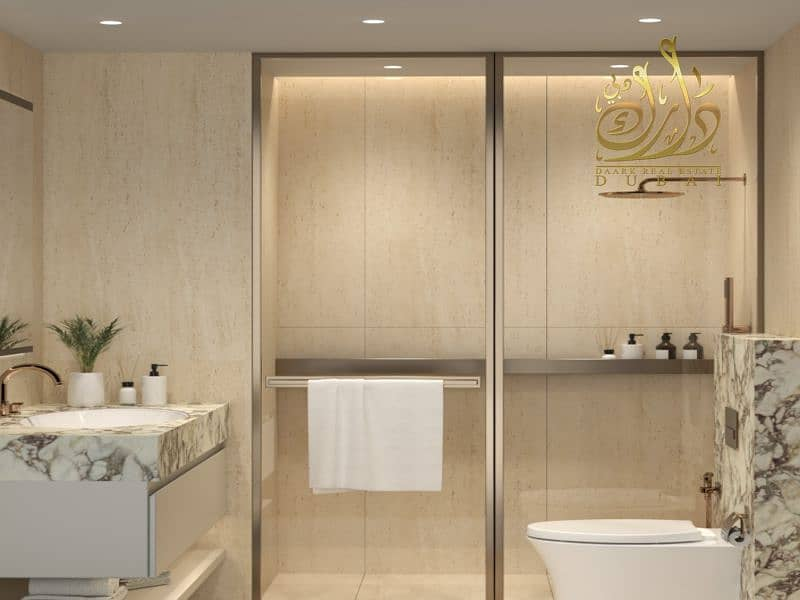

Score: 0.1443


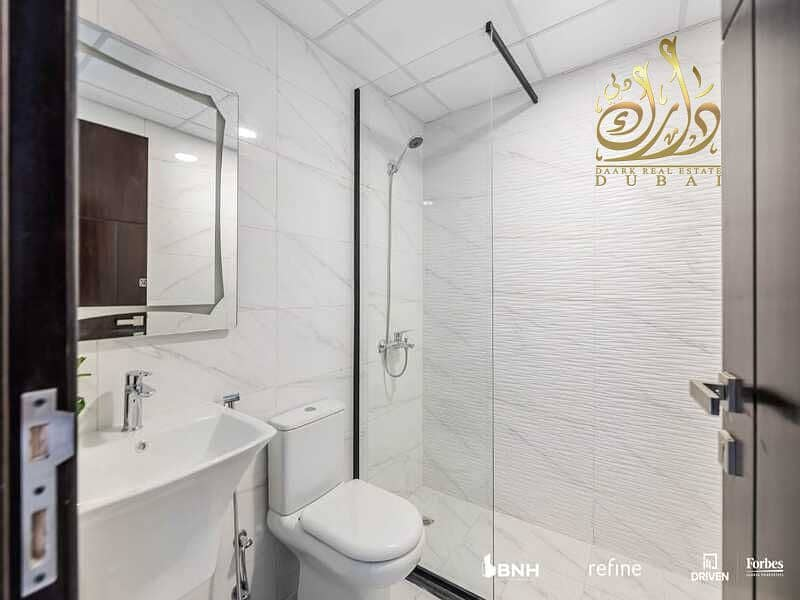

Score: 0.1356


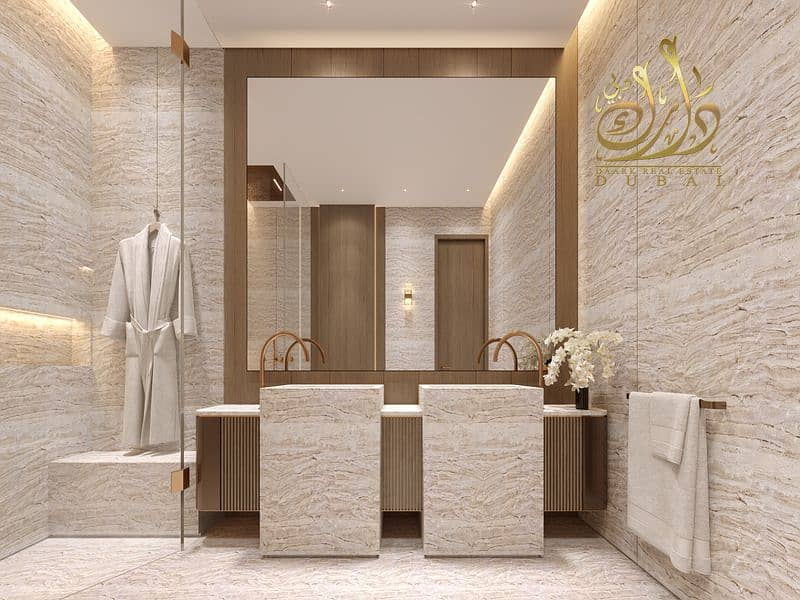

In [ ]:
from IPython.display import Image as IPythonImage, display

if not results_align:
    print("No results found above the threshold.")
else:
    for img_path, score in results_align:
        print(f"Score: {score:.4f}")
        display(IPythonImage(filename=img_path))


In [ ]:
import concurrent.futures
import time

# file_path = '/content/drive/My Drive/Building_images_test_case/10130844/'
# file_path = '/content/drive/My Drive/Building_images/'
image_dir = file_path
thing_to_detect = 'cat'
query = thing_to_detect

start_time = time.time()

model_clip, processor_clip = prepare_clip()
print("clip loaded")

end_time = time.time()
# Calculate runtime
runtime = end_time - start_time
print(f"Runtime: {runtime:.6f} seconds")

start_time = time.time()
# First code block encapsulated in a function
model_align, processor_align, device = prepare_align()
print("align loaded")

end_time = time.time()
# Calculate runtime
runtime = end_time - start_time
print(f"Runtime: {runtime:.6f} seconds")

start_time = time.time()

def run_clip(query, model_clip, processor_clip):
    image_embeddings_clip, model_clip, image_paths_clip = preprocess_clip(
        image_dir=image_dir,
        processor=processor_clip,
        model=model_clip
    )
    index_clip = embed_clip(image_embeddings_clip)
    results_clip = search_clip(
        query,
        index_clip,
        model_clip,
        image_paths_clip,
        top_k=2
    )
    return results_clip

def run_align(query, model_align, processor_align):
    image_embeddings_align, image_paths_align = preprocess_align(
            image_dir=image_dir,
            processor=processor_align,
            model=model_align,
            device=device
        )
    index_align = embed_align(image_embeddings_align)
    results_align = search_align(
        query=query,
        index=index_align,
        model=model_align,
        processor=processor_align,
        image_paths=image_paths_align,
        device=device,
        top_k=2
    )
    return results_align

def run():
    # Use ThreadPoolExecutor to run functions in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit both tasks to the executor
        future_align = executor.submit(run_align, query,  model_align, processor_align)
        future_clip = executor.submit(run_clip, query, model_clip, processor_clip)

        # Optionally, you can wait for both to complete and retrieve results
        result_align = future_align.result()
        result_clip = future_clip.result()

        # Process the results as needed
        print("Alignment Result:", result_align)
        print("CLIP Result:", result_clip)

    end_time = time.time()

    # Calculate runtime
    runtime = end_time - start_time
    print(f"Runtime: {runtime:.6f} seconds")

    return result_align, result_clip

results_align, results_clip = run()

clip loaded
Runtime: 9.209701 seconds
align loaded
Runtime: 3.139351 seconds
Mean Score: 0.14473828673362732
Standard Deviation: 0.0056340619921684265
Threshold: 0.14473828673362732
Mean Score: 0.08006756752729416
Standard Deviation: 0.0010813698172569275
Threshold: 0.115
Alignment Result: []
CLIP Result: [('/content/drive/My Drive/Building_images_train//744341889-800x600.jpeg', 0.15037236)]
Runtime: 10.407111 seconds


In [ ]:
align_dict = dict(results_align)
clip_dict = dict(results_clip)
print(align_dict)
print(clip_dict)

# Find common keys and calculate the sum of scores
common_elements = [(name, align_dict[name] + clip_dict[name])
                  for name in align_dict.keys() & clip_dict.keys()]

len_to_show = 20

if len(common_elements) < len_to_show:
    diffrence = len_to_show - len(common_elements)
    other_align = [(name, align_dict[name])
                  for name in align_dict.keys() - clip_dict.keys()]

    other_align = sorted(other_align, key=lambda x: x[1], reverse=True)
    other_align = other_align[:diffrence]

    # Use extend to add the tuples from other_align to common_elements
    common_elements.extend(other_align)

    print(common_elements)

sorted_elements = sorted(common_elements, key=lambda x: x[1], reverse=True)

if len(sorted_elements) < len_to_show:
    top_show = sorted_elements
else:
    top_show = sorted_elements[:len_to_show]

if top_show == []:
    try:
        top_show = results_align[:len_to_show]
    except:
        top_show = results_align


print(top_show)

{'/content/drive/My Drive/Building_images_train//744339941-800x600.jpeg': 0.08114894}
{'/content/drive/My Drive/Building_images_train//744341889-800x600.jpeg': 0.15037236}
[('/content/drive/My Drive/Building_images_train//744339941-800x600.jpeg', 0.08114894)]
[('/content/drive/My Drive/Building_images_train//744339941-800x600.jpeg', 0.08114894)]


Score: 0.0811


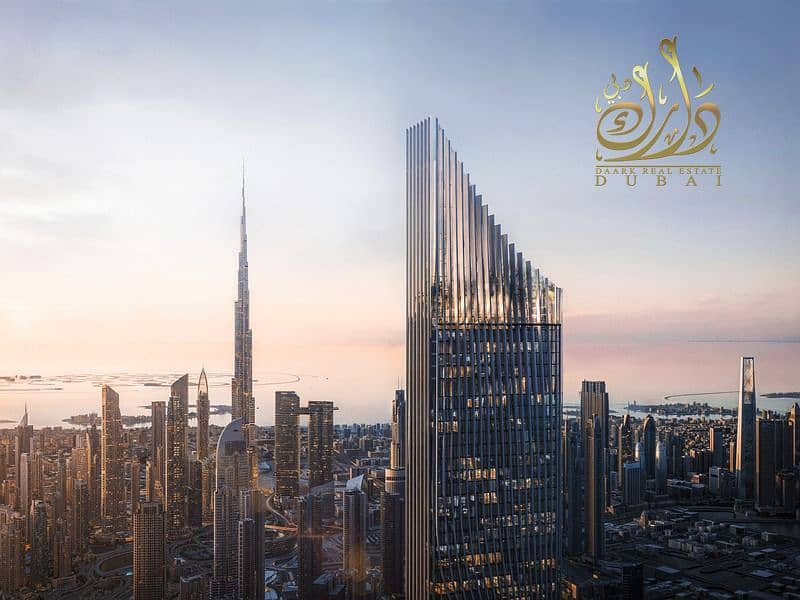

----------------------------------------------------------------------------------------------------


In [ ]:
for img_path, score in top_show:
    print(f"Score: {score:.4f}")
    display(IPythonImage(filename=img_path))
    print(100 * '-')